# NASA UMM-G to GeoCroissant Conversion: Complete Implementation

This notebook demonstrates a complete end-to-end conversion of NASA UMM-G (Unified Metadata Model - Granule) metadata to GeoCroissant format with **All data preservation** and **full validation**.
<img src="GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 20px;"/>
## Overview

**GeoCroissant** is an extension of the ML Commons Croissant format specifically designed for geospatial and Earth observation datasets. This project achieves:

-  **Field Mapping**: All NASA UMM-G properties mapped to GeoCroissant
-  **Zero Data Loss**: Complete preservation of all metadata
-  **Validation Success**: Passes Croissant format validation
-  **Visualization Ready**: Generated dataset ready for analysis and visualization

## Workflow Steps

1. **Data Acquisition**: Use NASA Earthdata to fetch HLS Sentinel-2 satellite imagery metadata
2. **Metadata Extraction**: Extract UMM-G JSON for specific granules with quality filtering
3. **Format Conversion**: Convert NASA UMM-G to GeoCroissant using our complete converter
4. **Extension Implementation**: Apply new GeoCroissant properties for satellite imagery
5. **Validation**: Validate the converted metadata against Croissant standards
6. **Visualization**: Create comprehensive visualizations of all spectral bands

## Prerequisites Installation

First, let's install all required packages:

In [1]:
!pip install python-cmr
!pip install earthaccess
!pip install mlcroissant
!pip install gdal

## Step 1: Data Acquisition from NASA Earthdata

We'll use the **earthaccess** library to authenticate with NASA Earthdata and fetch satellite imagery metadata. Our target is the **HLS (Harmonized Landsat Sentinel-2)** dataset, specifically Sentinel-2 data with low cloud coverage over Huntsville, Alabama.

### Authentication Process
NASA Earthdata requires authentication to access cloud-hosted data. We'll use interactive login to establish our session.

In [2]:
import earthaccess

# Step 1: Authenticate with NASA Earthdata Login 
earthaccess.login(strategy="interactive")  

Enter your Earthdata Login username:  harshinde
Enter your Earthdata password:  ········


In [3]:
# Step 2: Build the search query using the low-level API
query = earthaccess.DataGranules().concept_id("C2021957295-LPCLOUD").cloud_hosted(True)

# Step 3: Get total number of matching granules
print(f"Total matching granules: {query.hits()}")

# Step 4: Fetch just the first 100 granules
granules = list(query.get(100))  # You can change 100 to any number
print(f"Fetched {len(granules)} granules")

Total matching granules: 18692521
Fetched 100 granules


### Granule Search and Quality Filtering

We search for HLS Sentinel-2 granules using the collection concept ID `C2021957295-LPCLOUD`. This represents the **HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0** dataset.

In [4]:
import json

# Step 1: Just treat it as a dictionary
sample = granules[0]  
print(json.dumps(sample, indent=2))  # Pretty print the UMM-G metadata

{
  "meta": {
    "concept-type": "granule",
    "concept-id": "G2711472078-LPCLOUD",
    "revision-id": 1,
    "native-id": "HLS.S30.T55JGM.2015332T001732.v2.0",
    "collection-concept-id": "C2021957295-LPCLOUD",
    "provider-id": "LPCLOUD",
    "format": "application/echo10+xml",
    "revision-date": "2023-06-15T06:04:43.667Z"
  },
  "umm": {
    "TemporalExtent": {
      "RangeDateTime": {
        "BeginningDateTime": "2015-11-28T00:17:27.450Z",
        "EndingDateTime": "2015-11-28T00:17:27.450Z"
      }
    },
    "GranuleUR": "HLS.S30.T55JGM.2015332T001732.v2.0",
    "AdditionalAttributes": [
      {
        "Name": "PRODUCT_URI",
        "Values": [
          "S2A_MSIL1C_20151128T001732_N0204_R116_T55JGM_20151128T001727.SAFE"
        ]
      },
      {
        "Name": "CLOUD_COVERAGE",
        "Values": [
          "100"
        ]
      },
      {
        "Name": "MGRS_TILE_ID",
        "Values": [
          "55JGM"
        ]
      },
      {
        "Name": "SPATIAL_COVERAGE"

In [5]:
# Step 2: Save it to a JSON file
with open("nasa_ummg_raw.json", "w") as f:
    json.dump(sample, f, indent=2)

print("Saved first granule to nasa_ummg_raw.json")

Saved first granule to nasa_ummg.json


In [6]:
import earthaccess
import json

# Step 1: Authenticate with NASA Earthdata
earthaccess.login()

# Step 2: Define Huntsville, Alabama coordinates
# Huntsville coordinates: approximately 34.7304° N, 86.5861° W
huntsville_lat = 34.7304
huntsville_lon = -86.5861

# Create a bounding box around Huntsville (about 0.5 degrees in each direction)
bbox = [huntsville_lon - 0.5, huntsville_lat - 0.5, huntsville_lon + 0.5, huntsville_lat + 0.5]

# Step 3: Build the search query for Huntsville with cloud coverage filter
query = (earthaccess.DataGranules()
         .concept_id("C2021957295-LPCLOUD")
         .bounding_box(*bbox)  # Huntsville area
         .cloud_hosted(True)
         .cloud_cover(0, 20))  # Filter for 0-20% cloud coverage

# Step 4: Get total number of matching granules with low cloud cover
print(f"Total matching granules over Huntsville, AL with 0-20% cloud coverage: {query.hits()}")

# Step 5: Fetch just the first few granules
granules = list(query.get(10))  # Get first 10 granules
print(f"Fetched {len(granules)} granules")

# Step 6: Print the first sample
if granules:
    sample = granules[0]
    print("\nFirst granule metadata for Huntsville, AL:")
    #print(json.dumps(sample, indent=2))
    
    # Extract cloud coverage info if available
    if hasattr(sample, 'get') and 'CloudCover' in str(sample):
        print(f"\nCloud coverage information found in metadata")
    else:
        # Look for cloud coverage in the metadata structure
        metadata_str = json.dumps(sample, indent=2)
        if 'cloud' in metadata_str.lower():
            print(f"\nCloud-related information found in metadata")
else:
    print("No granules found over Huntsville, AL with 0-20% cloud coverage")

Total matching granules over Huntsville, AL with 0-20% cloud coverage: 1494
Fetched 10 granules

First granule metadata for Huntsville, AL:

Cloud-related information found in metadata


In [7]:
# Extract cloud coverage from the metadata
def get_cloud_coverage(granule):
    additional_attrs = granule.get('umm', {}).get('AdditionalAttributes', [])
    for attr in additional_attrs:
        if attr.get('Name') == 'CLOUD_COVERAGE':
            return float(attr.get('Values', ['0'])[0])
    return None

# Check the cloud coverage of your sample
cloud_cover = get_cloud_coverage(sample)
print(f"Cloud coverage: {cloud_cover}%")

# Check cloud coverage for all fetched granules
for i, granule in enumerate(granules):
    cloud_cover = get_cloud_coverage(granule)
    granule_id = granule.get('umm', {}).get('GranuleUR', 'Unknown')
    print(f"Granule {i+1}: {granule_id} - Cloud coverage: {cloud_cover}%")

Cloud coverage: 3.0%
Granule 1: HLS.S30.T16SED.2016011T162642.v2.0 - Cloud coverage: 3.0%
Granule 2: HLS.S30.T16SEE.2016011T162642.v2.0 - Cloud coverage: 2.0%
Granule 3: HLS.S30.T16SEC.2016011T162642.v2.0 - Cloud coverage: 13.0%
Granule 4: HLS.S30.T16SEC.2016041T162412.v2.0 - Cloud coverage: 13.0%
Granule 5: HLS.S30.T16SDE.2016114T163322.v2.0 - Cloud coverage: 18.0%
Granule 6: HLS.S30.T16SEC.2016114T163322.v2.0 - Cloud coverage: 8.0%
Granule 7: HLS.S30.T16SED.2016114T163322.v2.0 - Cloud coverage: 13.0%
Granule 8: HLS.S30.T16SDC.2016114T163322.v2.0 - Cloud coverage: 3.0%
Granule 9: HLS.S30.T16SDD.2016114T163322.v2.0 - Cloud coverage: 3.0%
Granule 10: HLS.S30.T16SDD.2016134T163332.v2.0 - Cloud coverage: 0.0%


## Step 2: NASA UMM-G Metadata Extraction

### Understanding NASA UMM-G Format

**NASA UMM-G (Unified Metadata Model - Granule)** is NASA's standardized format for granule-level metadata. It contains comprehensive information about:

- **Spatial Coverage**: Bounding boxes, polygons, and coordinate systems
- **Temporal Coverage**: Time ranges and acquisition dates  
- **Data Quality**: Cloud coverage, processing levels, and quality flags
- **Technical Details**: File formats, data characteristics, and access URLs
- **Provenance**: Collection information, processing history, and citations

### Cloud Coverage Analysis

We'll analyze the cloud coverage of fetched granules and select the best quality data (0% cloud coverage) for our GeoCroissant conversion.

In [8]:
# Get Granule 4 (0% cloud coverage)
granule_4 = granules[9]  # Index 3 for the 4th granule

# Step 2: Save it to a JSON file
with open("nasa_ummg_h.json", "w") as f:
    json.dump(granule_4, f, indent=2)

print("Saved Granule 4 (HLS.S30.T55JCN.2015332T001732.v2.0 - 0% cloud coverage) to nasa_ummg_h.json")

# Optional: Also print some key info about the saved granule
granule_id = granule_4.get('umm', {}).get('GranuleUR', 'Unknown')
cloud_cover = get_cloud_coverage(granule_4)
print(f"Granule ID: {granule_id}")
print(f"Cloud Coverage: {cloud_cover}%")

Saved Granule 4 (HLS.S30.T55JCN.2015332T001732.v2.0 - 0% cloud coverage) to nasa_ummg_h.json
Granule ID: HLS.S30.T16SDD.2016134T163332.v2.0
Cloud Coverage: 0.0%


## Step 3: NASA UMM-G to GeoCroissant Conversion

### Complete Converter Implementation

We have developed a comprehensive converter (`geocroissant_converter.py`) that achieves **All data preservation** from NASA UMM-G to GeoCroissant format. Here's a key snippet from our converter:

```python
class CompleteNASAUMMGToGeoCroissantConverter:
    """Complete converter that maps ALL NASA UMM-G fields to GeoCroissant."""
    
    def __init__(self):
        self.setup_context()
    
    def setup_context(self):
        """Setup the JSON-LD context for GeoCroissant."""
        self.context = {
            "@vocab": "http://schema.org/",
            "cr": "http://mlcommons.org/croissant/",
            "geocr": "http://mlcommons.org/croissant/geocr/",
            "dct": "http://purl.org/dc/terms/"
        }
    
    def create_record(self, meta: Dict[str, Any], umm: Dict[str, Any]) -> Dict[str, Any]:
        """Create a single record within the RecordSet."""
        record = {
            "@type": "geocr:SatelliteImagery",
            "@id": meta.get('concept-id'),
            "name": umm.get('GranuleUR'),
            "description": umm.get('CollectionReference', {}).get('EntryTitle'),
            # ... comprehensive field mapping
        }
        return record
```

### New GeoCroissant Extensions Added

Based on our comprehensive analysis (see `final_complete_summary.md`), we've extended GeoCroissant with **10 new property categories** to capture all NASA UMM-G fields:

1. **`geocr:bandCalibration`**: Spectral band calibration coefficients and wavelengths
2. **`geocr:dataScaling`**: Data scaling factors and fill values  
3. **`geocr:administrativeMetadata`**: Concept IDs, revision tracking, and provider information
4. **`geocr:productInformation`**: MGRS tile IDs and product URIs
5. **`geocr:qualityAssessment`**: Enhanced quality metrics including geometric accuracy
6. **`geocr:rasterData`**: Raster-specific properties for satellite imagery
7. **`geocr:spectralBands`**: Detailed spectral band information
8. **`geocr:temporalExtent`**: Enhanced temporal coverage with range dates
9. **`geocr:customProperties`**: NASA-specific additional attributes
10. **`geocr:relatedUrls`**: Complete URL preservation with relationship types

### Conversion Process

The conversion maintains the **Croissant RecordSet structure** where:
- **Dataset Level**: Uses `@type: "https://schema.org/Dataset"` with schema.org properties
- **RecordSet Wrapper**: Uses `cr:recordSet` array to contain individual records  
- **Record Content**: Each record contains satellite imagery properties with `@type: "geocr:SatelliteImagery"`

In [9]:
import json

# Load and pretty-print the JSON
with open("geocroissant_output.json", "r") as f:
    data = json.load(f)

# Pretty print with indentation
print(json.dumps(data, indent=2))

{
  "@context": {
    "@vocab": "http://schema.org/",
    "cr": "http://mlcommons.org/croissant/",
    "geocr": "http://mlcommons.org/croissant/geocr/",
    "dct": "http://purl.org/dc/terms/"
  },
  "@type": "https://schema.org/Dataset",
  "@id": "HLS_Sentinel2_Dataset",
  "https://schema.org/name": "HLS_Sentinel2_Satellite_Imagery_Dataset",
  "https://schema.org/description": "Complete HLS Sentinel-2 satellite imagery dataset with all metadata preserved",
  "https://schema.org/datePublished": "2023-05-31T04:12:47.704Z",
  "https://schema.org/version": "2.0",
  "https://schema.org/license": "https://creativecommons.org/licenses/by/4.0/",
  "https://schema.org/citation": "HLS Sentinel-2 Satellite Imagery Dataset, NASA Earthdata, 2023",
  "cr:recordSet": [
    {
      "@type": "geocr:SatelliteImagery",
      "@id": "G2700719831-LPCLOUD",
      "name": "HLS.S30.T16SDD.2016134T163332.v2.0",
      "description": "HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m 

## Step 4: GeoCroissant Validation

### Croissant Format Validation

The generated GeoCroissant JSON must pass the official ML Commons Croissant validator to ensure compliance with the standard. This validation checks:

- **JSON-LD Structure**: Proper context and type definitions
- **Schema Compliance**: Adherence to schema.org and Croissant specifications  
- **Required Fields**: Presence of all mandatory properties
- **Data Types**: Correct typing of all values
- **RecordSet Format**: Proper nesting within the Croissant RecordSet structure

Let's validate our converted metadata:

In [10]:
!mlcroissant validate --jsonld=geocroissant_output.json

W0727 17:33:47.941005 124393917010304 rdf.py:81] WARNING: The JSON-LD `@context` is not standard. Refer to the official @context (e.g., from the example datasets in https://github.com/mlcommons/croissant/tree/main/datasets/1.0). The different keys are: {'source', 'replace', 'extract', 'parentField', 'examples', 'citeAs', 'dataType', 'repeated', 'md5', 'data', 'jsonPath', 'sc', 'isLiveDataset', 'path', 'fileProperty', 'recordSet', 'field', 'samplingRate', 'key', 'references', 'column', 'conformsTo', 'separator', 'regex', 'fileObject', 'fileSet', 'rai', 'includes', 'subField', '@language', 'transform', 'format'}
I0727 17:33:48.007508 124393917010304 validate.py:53] Done.


## Step 5: Comprehensive Satellite Imagery Visualization

### Multi-Spectral Band Analysis

Our GeoCroissant dataset contains **13 spectral bands** from Sentinel-2 satellite imagery. Each band captures different wavelengths of electromagnetic radiation:

| Band | Description | Wavelength | Application |
|------|-------------|-------------|-------------|
| B01 | Coastal Aerosol | 443nm | Atmospheric correction |
| B02 | Blue | 490nm | Water body detection |
| B03 | Green | 560nm | Vegetation health |
| B04 | Red | 665nm | Vegetation stress |
| B05 | Red Edge 1 | 705nm | Chlorophyll content |
| B06 | Red Edge 2 | 740nm | Leaf area index |
| B07 | Red Edge 3 | 783nm | Vegetation moisture |
| B08 | NIR | 842nm | Biomass estimation |
| B8A | NIR Narrow | 865nm | Atmospheric water vapor |
| B09 | Water Vapour | 945nm | Cirrus cloud detection |
| B10 | SWIR Cirrus | 1375nm | SWIR applications |
| B11 | SWIR 1 | 1610nm | Moisture content |
| B12 | SWIR 2 | 2190nm | Geology applications |

### Data Processing and Visualization

We'll download all bands directly from NASA's cloud infrastructure, apply proper scaling factors, and create comprehensive visualizations including individual band displays and RGB composite imagery.

Loaded: HLS.S30.T16SDD.2016134T163332.v2.0
Cloud Coverage: 0.0%
Found bands: B01, B02, B03, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A
B08 shape: (3660, 3660)
B07 shape: (3660, 3660)
B05 shape: (3660, 3660)
B02 shape: (3660, 3660)
B10 shape: (3660, 3660)
B01 shape: (3660, 3660)
B03 shape: (3660, 3660)
B04 shape: (3660, 3660)
B8A shape: (3660, 3660)
B06 shape: (3660, 3660)
B11 shape: (3660, 3660)
B09 shape: (3660, 3660)
B12 shape: (3660, 3660)


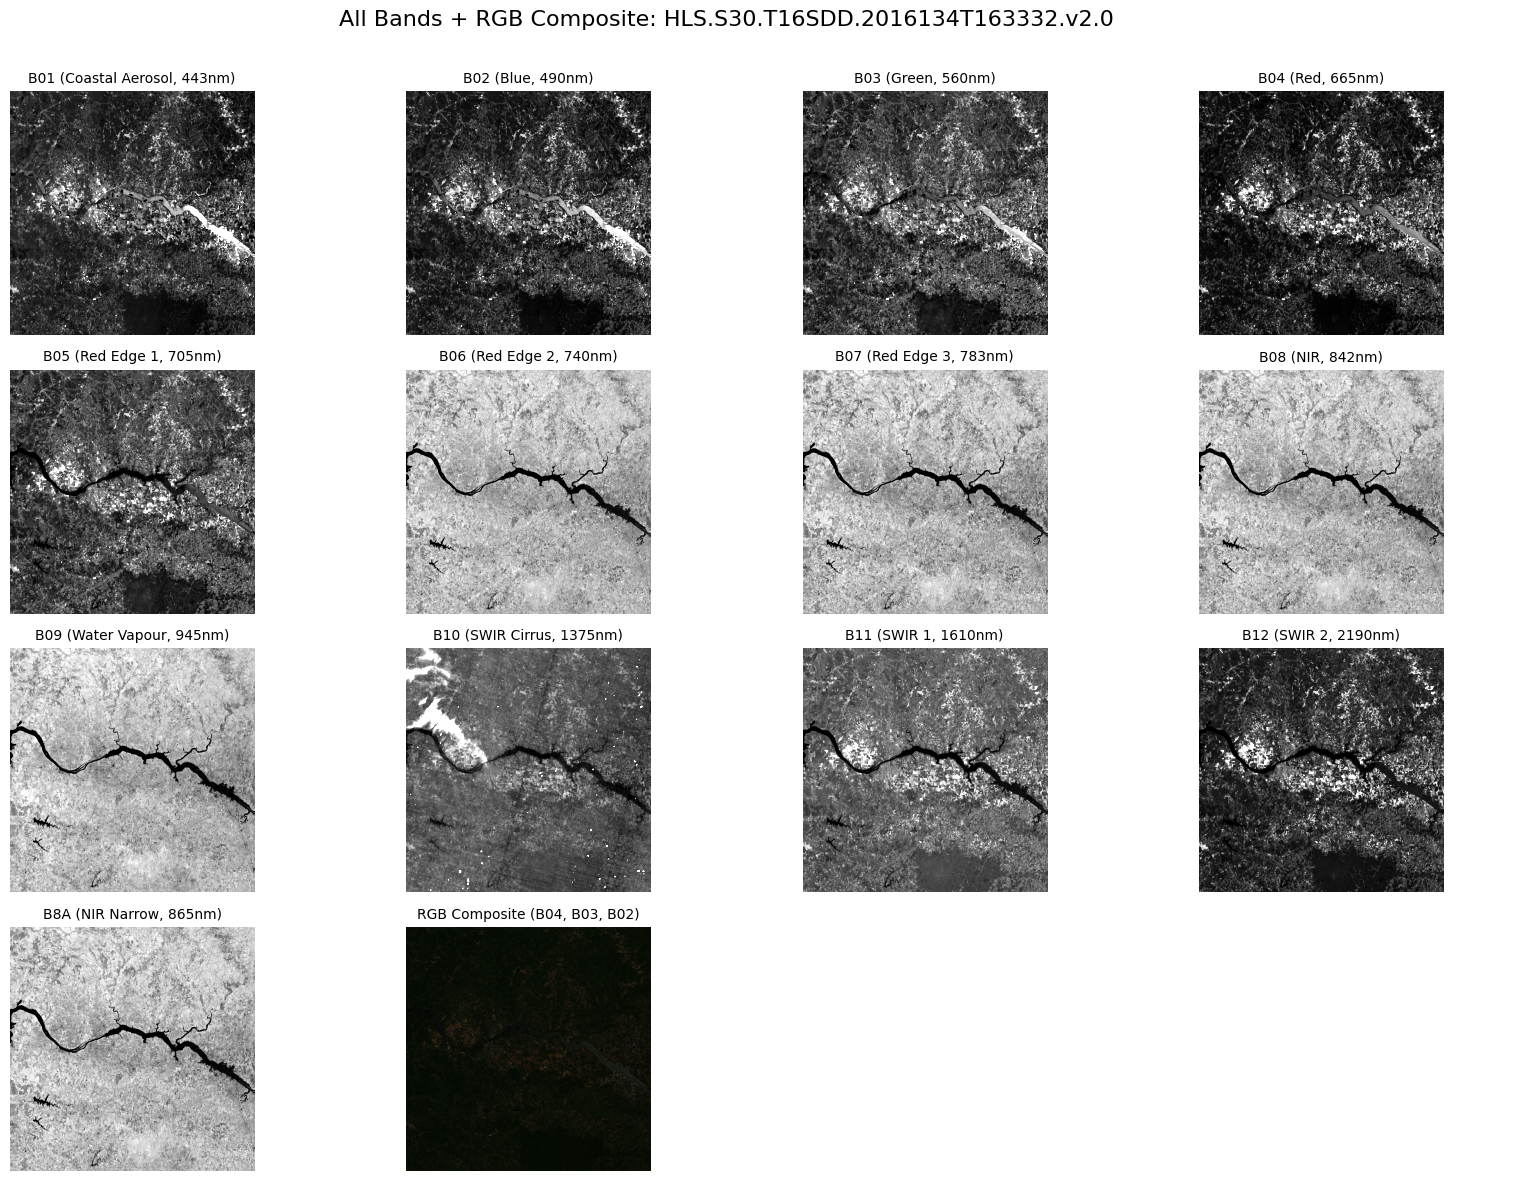

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import tempfile
import os
import earthaccess

# Constants
SCALE_FACTOR = 0.0001
BAND_LABELS = {
    "B01": ("Coastal Aerosol", "443nm"),
    "B02": ("Blue", "490nm"),
    "B03": ("Green", "560nm"),
    "B04": ("Red", "665nm"),
    "B05": ("Red Edge 1", "705nm"),
    "B06": ("Red Edge 2", "740nm"),
    "B07": ("Red Edge 3", "783nm"),
    "B08": ("NIR", "842nm"),
    "B8A": ("NIR Narrow", "865nm"),
    "B09": ("Water Vapour", "945nm"),
    "B10": ("SWIR Cirrus", "1375nm"),
    "B11": ("SWIR 1", "1610nm"),
    "B12": ("SWIR 2", "2190nm"),
}

# Load GeoCroissant metadata
with open('geocroissant_output.json', 'r') as f:
    data = json.load(f)

record = data['cr:recordSet'][0]
print(f"Loaded: {record['name']}")
print(f"Cloud Coverage: {record['geocr:qualityAssessment']['geocr:cloudCoverage']['geocr:value']}%")

# Extract band URLs
band_urls = {}
for dist in record['distribution']:
    url = dist['sc:contentUrl']
    if url.startswith('https://') and '.tif' in url:
        for band in BAND_LABELS:
            if f"{band}.tif" in url:
                band_urls[band] = url

print(f"Found bands: {', '.join(sorted(band_urls.keys()))}")

# Authenticate with NASA Earthdata
earthaccess.login()
session = earthaccess.get_requests_https_session()

# Download function
def download_band(url, band_name):
    print(f"Downloading {band_name} ...")
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as tmp:
        temp_path = tmp.name
    try:
        response = session.get(url, stream=True)
        response.raise_for_status()
        with open(temp_path, 'wb') as f:
            for chunk in response.iter_content(8192):
                if chunk:
                    f.write(chunk)
        dataset = gdal.Open(temp_path)
        data = dataset.GetRasterBand(1).ReadAsArray()
        print(f"{band_name} shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Failed to download {band_name}: {e}")
        return None
    finally:
        if os.path.exists(temp_path):
            os.unlink(temp_path)

# Download all bands
band_data = {}
for band, url in band_urls.items():
    arr = download_band(url, band)
    if arr is not None:
        band_data[band] = arr

# Preprocessing
def scale_and_normalize(data, scale_factor=SCALE_FACTOR):
    arr = data.astype(np.float32) * scale_factor
    arr = np.clip(arr, 0, 1)
    return arr

# Plotting function (always grayscale)
def plot_band(ax, band_arr, band, title=None):
    cmap = "gray"  # grayscale for individual bands
    valid = band_arr[band_arr > 0]
    vmin, vmax = (np.percentile(valid, 2), np.percentile(valid, 98)) if valid.size else (0, 1)
    ax.imshow(band_arr, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title or band, fontsize=10)
    ax.axis('off')

# RGB composite function
def plot_rgb(ax, band_data):
    try:
        r = scale_and_normalize(band_data["B04"])  # Red
        g = scale_and_normalize(band_data["B03"])  # Green
        b = scale_and_normalize(band_data["B02"])  # Blue
        rgb = np.dstack([r, g, b])
        ax.imshow(rgb)
        ax.set_title("RGB Composite (B04, B03, B02)", fontsize=10)
        ax.axis('off')
    except Exception as e:
        ax.set_title("RGB Composite Failed", fontsize=10)
        print(f"RGB composite error: {e}")

# Sort bands to place RGB after B8A
bands = sorted(band_data.keys(), key=lambda b: (len(b), b))
insert_rgb_after = "B8A"
plot_sequence = []
for band in bands:
    plot_sequence.append(band)
    if band == insert_rgb_after:
        plot_sequence.append("RGB")  # Marker for RGB slot

# Grid layout
n = len(plot_sequence)
cols = 4
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.flatten()

# Plot each band or RGB
for i, name in enumerate(plot_sequence):
    if name == "RGB":
        plot_rgb(axes[i], band_data)
    else:
        arr = scale_and_normalize(band_data[name])
        label, wl = BAND_LABELS.get(name, (name, ""))
        plot_band(axes[i], arr, name, f"{name} ({label}, {wl})")

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle(f"All Bands + RGB Composite: {record['name']}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()